This notebook applies different models to forecast the taxi demand for the 20 busiest areas in NYC. An ARIMA model is used as well as some simple baseline models. The dataset contains data of 2009 up to 2018. The first two years (2009 and 2010) are used as training set. 

## Import modules

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import seaborn as sns
#plt.style.use('seaborn-whitegrid')

import pickle

import datetime
from dateutil.relativedelta import relativedelta

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import itertools

import os
#from tqdm import tqdm


import random


from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA


from pyramid.arima import auto_arima
from pyramid.arima.utils import nsdiffs
from pyramid.arima.utils import ndiffs
from pyramid.arima.stationarity import ADFTest

from warnings import catch_warnings
from warnings import filterwarnings

#from multiprocessing import cpu_count
#from joblib import Parallel
#from joblib import delayed


## Load Data

In [2]:
#load data
TRAIN_PATH = '/media/...'
Store_PATH = '/media/...'
file_final = 'preprocessed_dataset.csv'

df_m = pd.read_csv(TRAIN_PATH + file_final, header=0)
#print(df_m.head())

#convert to datetime format:
df_m['date'] = pd.to_datetime(df_m['date'], utc=True)
df_m['date'] = df_m['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_m['date'] = pd.to_datetime(df_m['date'])
#df_m = df_m.set_index("date") -> set index later, since we need "date" column to find highest demand columns..
print(df_m.head())

                 date  1  2  3    4  5  6   7  8  9  ...  254  255  256  257  \
0 2009-01-01 05:00:00  0  0  0   91  0  0  30  0  0  ...    0   50   39    3   
1 2009-01-01 06:00:00  1  0  0  105  0  0  62  0  0  ...    0   77   67    5   
2 2009-01-01 07:00:00  0  0  0   96  0  0  79  0  0  ...    0   90   83    4   
3 2009-01-01 08:00:00  0  0  0   91  0  0  84  0  0  ...    0   54   77    3   
4 2009-01-01 09:00:00  2  0  0   82  0  0  85  0  1  ...    0   66   54    4   

   258  259  260  261  262  263  
0    1    0    3   52  127  326  
1    0    0   15   65  166  476  
2    0    0   19   39  125  460  
3    1    0   19   54   79  313  
4    0    0   13   24   47  224  

[5 rows x 264 columns]


In [3]:
'''filter areas with highest demand '''
#get time series with highest "demand patterns":

#function filters nlargest areas:
def get_nlargest_areas(nlargest, org_dataset = df_m):
    
    #get time series with highest "demand patterns":
    df_sum = org_dataset.copy(deep=True).drop(columns=["date"],axis=1)
    df_sum = df_sum.sum(axis=0,numeric_only=True)

    #store nlargest values:
    df_sum = df_sum.nlargest(nlargest) 
    idx_filter = list(df_sum.index.values)
    #append "date" column
    idx_filter.append("date")

    del df_sum
    
    #filter columns with largest values:
    ts_largest = org_dataset[idx_filter].copy(deep=True)
    ts_largest = ts_largest.set_index("date")

    #shift datetimeindex to use local NYC time not UTC:
    ts_largest.index = ts_largest.index.shift(-5,freq='H')

    return ts_largest


In [4]:
ts_20largest = get_nlargest_areas(20)
ts_10largest = get_nlargest_areas(10)

print('20 largest areas: ', ts_20largest.shape)
print('10 largest areas: ', ts_10largest.shape)


20 largest areas:  (83231, 20)
10 largest areas:  (83231, 10)


### Functions to analyze & transform time series

#### differencing

In [5]:
''' ## Differencing '''
#make timeseries stationary
# Simple differencing: -> Note: if we use ARIMA with "d" = 1 differencing-function is not needed, since it is done by ARIMA

def differencing(dataset,shift_interval):
    dataset_copy = dataset.copy(deep=True)
    shifted_df = dataset_copy.shift(shift_interval)
    diff_series = dataset_copy - shifted_df
    diff_series.dropna(inplace=True)
    return diff_series



# invert differenced values 
def invert_differencing(history, prediction, year_to_invert, shift_term):
    history_copy = history.copy()
    history_shift = history_copy.shift(shift_term)
    history_shift.dropna(inplace=True)
    
    print('Shape of org. dataset after shift: ', history_shift.loc[year_to_invert].shape)
    
    history_shift_year =  history_shift.loc[year_to_invert]
    
    return prediction + history_shift_year





In [6]:
def multiple_invert_differencing(history, prediction, shift_term_order_list):
    
    '''
    Inverts differencing scheme if differencing is applied multiple times after another
    '''
    
    prediction_shifted = prediction.copy()
    
    while shift_term_order_list:
        history_copy = history.copy()
        for u in range(len(shift_term_order_list)-1):

            #first difference up to second last entry:
            history_diff = differencing(history_copy,shift_term_order_list[u])
            history_copy = history_diff 

        #shift differenced series:
        history_copy = history_copy.shift(shift_term_order_list[-1])
        history_copy.dropna(inplace=True)


        #match with index of current predictions:
        history_shift_year = history_copy[history_copy.index.isin(list(prediction_shifted.index))]    

        #print('Shape of org. dataset after diff & shift: ', history_shift_year.shape)
        #print('head:', history_shift_year.head())

        prediction_shifted = prediction_shifted + history_shift_year

        #delete last item in list:
        del shift_term_order_list[-1]
        
        
    
    return prediction_shifted



#### adfuller

In [7]:
# check if stationary with augmented Dickey-Fuller test
def adfuller_test(ts_series):
    result = adfuller(ts_series)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    return result[0], result[1]

#### functions to plot series 

In [8]:
def get_lowess(ts_series):
    
    #statsmodel prepare lowess data:
    ts_to_lowess = pd.DataFrame(ts_series.copy())
    ts_to_lowess.reset_index(inplace=True)

    lowess = sm.nonparametric.lowess(ts_to_lowess.iloc[:,1], ts_to_lowess.index, frac=.66)
    
    # unpack the lowess smoothed points to their values
    lowess_x = list(zip(*lowess))[0]
    lowess_y = list(zip(*lowess))[1]
    
    
    ts_to_plot = pd.DataFrame(ts_series.copy())
    ts_to_plot['lowess_y'] = lowess_y
    #ts_to_plot.head()
    
    return ts_to_plot



In [17]:
#get glimpse into data:

def plot_series_and_histogram(ts_series, start_date = '2009-03-01', date_range=1, plot_lowess=False, plot_title=None):
    end_date = pd.Timestamp(start_date) + relativedelta(months=date_range)
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(ts_series[start_date:str(end_date)], label='Actual Demand')
    


    if plot_lowess == True:
        
        ts_to_plot = get_lowess(ts_series[start_date:str(end_date)])
        #plot lowess curve:
        ax.plot(ts_to_plot['lowess_y'], label='LOWESS', color='orange')
    

    if date_range > 2:
        ax.xaxis.set_minor_locator(mdates.MonthLocator()) 
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
        ax.xaxis.set_major_locator(mdates.YearLocator()) 
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    else:
        ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1)) #plot ticks every 1 weeks
        #ax.xaxis.set_minor_locator(mdates.DayLocator()) 
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m/%d'))
        ax.xaxis.set_major_locator(mdates.YearLocator()) 
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
 
    
    ax.set_title('{}'.format(plot_title), fontsize=14, fontweight = 'bold')
    ax.set_ylabel('Demand', fontsize=14)
    ax.set_xlabel('Date', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    
    #ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    
    ax.legend(fontsize=14)
    
    ax.grid(linewidth=0.5)
    
    fig.autofmt_xdate()
    
    plt.show()
    
    return fig


In [10]:
#get glimpse into data:

def plot_3weeks_march_and_histogram(ts_series):
    fig, ax = plt.subplots(2,1,figsize=(12,8))
    ax[0].plot(ts_series['2009-03-01':'2009-03-14'])
    ax[0].xaxis.set_major_locator(mdates.DayLocator())
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    #fig.autofmt_xdate()
    
    #plot histogram of demand:
    ax[1].hist(ts_series['2009-03-01':'2009-03-14'], bins=20)
    
    
    plt.show()
    
    
    return fig

In [11]:
#plots histogram of given series
def plot_hist(ts_series, n_bins=20, plot_title=''):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.hist(ts_series, bins=n_bins)
    ax.set_title('{}'.format(plot_title), fontsize=14, fontweight = 'bold')
    
    plt.show()
    
    return fig

In [12]:
def plot_dist(ts_series, n_bins=20, plot_title=''):
    fig, axs = plt.subplots(figsize=(12,8))
    dist = sns.distplot(ts_series, bins=n_bins, kde=True, ax = axs,
                       kde_kws={"label": "KDE"})
    axs.set_title('{}'.format(plot_title), fontsize=14, fontweight = 'bold')
    axs.legend()
    plt.show()
    
    return fig

In [13]:
def multi_plot_dist(first_ts_series, second_ts_series, n_bins=20, first_plot_title='', second_plot_title=''):
    fig, axs = plt.subplots(2,1,figsize=(12,8))
    first_dist = sns.distplot(first_ts_series, bins=n_bins, kde=True, ax = axs[0],
                       kde_kws={"label": "KDE"})
    sec_dist = sns.distplot(second_ts_series, bins=n_bins, kde=True, ax = axs[1],
                       kde_kws={"label": "KDE"})
        
    axs[0].set_title('{}'.format(first_plot_title), fontsize=14)
    axs[1].set_title('{}'.format(second_plot_title), fontsize=14)
    
    axs[0].legend()
    axs[1].legend()
    
    plt.show()
    
    return fig

#### ACF & PACF plot functions

In [14]:
#plot ACF: 
def plot_acf_only(ts_series, n_lags=50):
    #plot Autocorrelation & Partial Autocorrelation:
    fig, axs = plt.subplots(figsize=(12,8))
    plot_acf(ts_series, alpha = 0.05, lags=n_lags, ax=axs)
    
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.tick_params(axis='both', which='minor', labelsize=14)
    
    axs.set_xlabel('Lags', fontsize=14)
    
    #axs.yaxis.set_major_locator(plt.MaxNLocator(6))
    pyplot.locator_params(axis='y', nbins=6)
    
    plt.show() 
    
    return fig

In [15]:
#plot ACF & PACF: 
def plot_acf_pacf(ts_series, n_lags=50):
    #plot Autocorrelation & Partial Autocorrelation:
    fig, axs = plt.subplots(2,1,figsize=(12,8))
    plot_acf(ts_series, alpha = 0.05, lags=n_lags, ax=axs[0])
    plot_pacf(ts_series, alpha = 0.05, lags=n_lags, ax=axs[1])
    
    axs[0].set_xlabel('Lags', fontsize=14)
    axs[1].set_xlabel('Lags', fontsize=14)
    
    axs[0].tick_params(axis='both', which='major', labelsize=14)
    axs[0].tick_params(axis='both', which='minor', labelsize=14)
    
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    axs[1].tick_params(axis='both', which='minor', labelsize=14)
    
    axs[0].set_title('Autocorrelation', fontsize=14, fontweight='bold')
    axs[1].set_title('Partial Autocorrelation',fontsize=14, fontweight='bold')
    
    axs[0].yaxis.set_major_locator(plt.MaxNLocator(6))
    axs[1].yaxis.set_major_locator(plt.MaxNLocator(6))
    #plt.locator_params(axis='y', nbins=6)
    
    plt.subplots_adjust(hspace=0.4) 
    plt.show() 
    
    return fig

## Analyze Time Series:

In [7]:
'''Prepare Time Series '''   

#labels of 20 largest areas:
column_labels = list(ts_20largest.columns)

ts_series_single_area = ts_20largest.iloc[:,0].copy()


### Sample Plots

/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


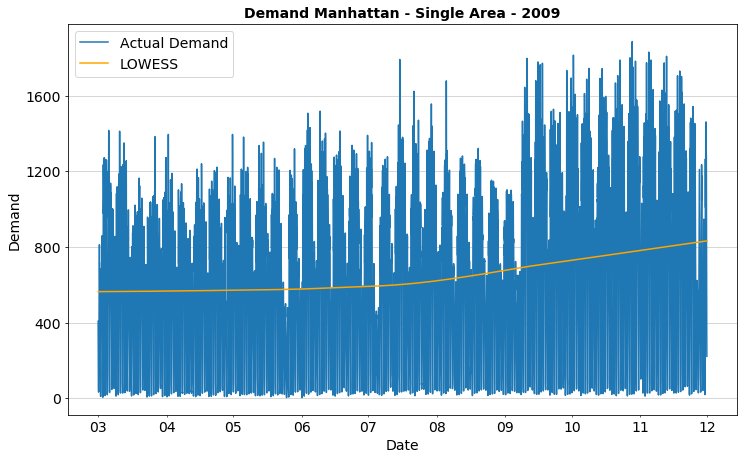

In [18]:
#plot time series with LOWESS & without differencing:
fig_months = plot_series_and_histogram(ts_series_single_area, start_date = '2009-03-01', date_range=9, plot_lowess=True, 
                                       plot_title='Demand Manhattan - Single Area - 2009')

#save on Disk:
#df_ARIMA_preds_PATH = '/media/...'
#fig_months.savefig(df_ARIMA_preds_PATH + 'Demand_Area237_9Monhts.jpeg', dpi=196)


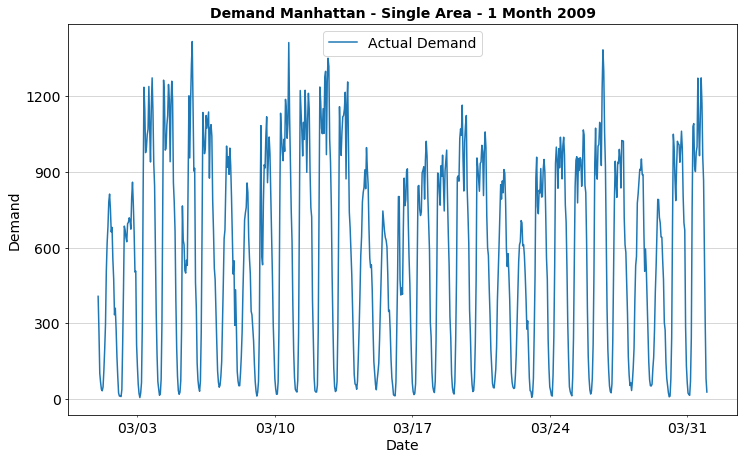

In [19]:
#plot time series with LOWESS & without differencing:
fig_month = plot_series_and_histogram(ts_series_single_area, start_date = '2009-03-01', date_range=1, plot_lowess=False, 
                                      plot_title='Demand Manhattan - Single Area - 1 Month 2009')


### ACF & PACF Plots

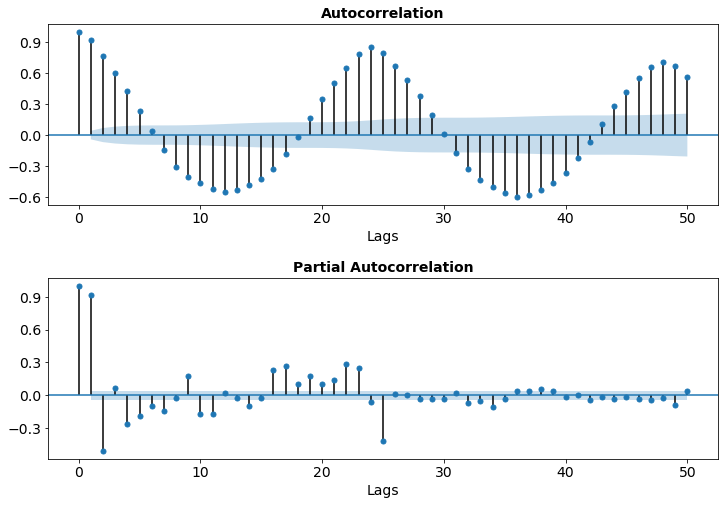

In [57]:
ts_series_to_plot = ts_series_single_area.loc['2009-03-01':'2009-05']
fig_acf = plot_acf_pacf(ts_series_to_plot, n_lags=50)


### 3 weeks Plots & Histogram

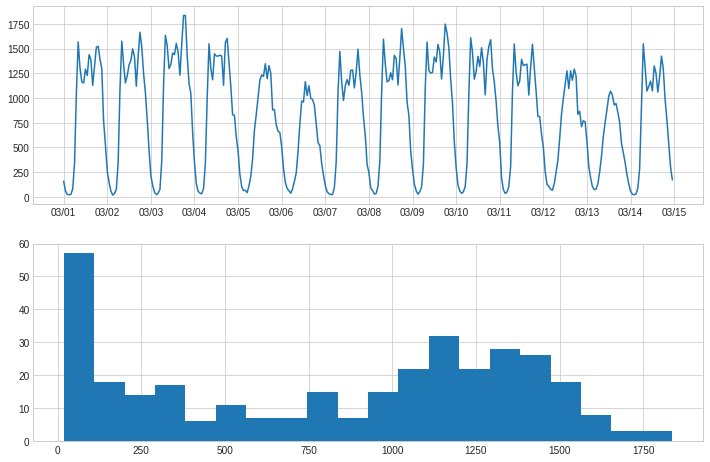

In [14]:
#plot time series without differencing:
fig = plot_3weeks_march_and_histogram(ts_series_single_area)


### Apply Differencing if needed:

In [10]:
# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.is_stationary(ts_series_single_area)  # (0.99, False)


# estimate number of regular differences
regul_Diff_needed = ndiffs(ts_series_single_area,
                           max_d=12,
                           alpha=0.05,
                           test='kpss')


# estimate number of seasonal differences
season_Diff_needed = nsdiffs(ts_series_single_area,
                           m = 7, #daily periodicity
                           max_D=170,
                           test='ch')


print('p_value: ', p_val)
print('should_diff: ', should_diff)
print('regul_Diff_needed: ', regul_Diff_needed)
print('season_Diff_needed: ', season_Diff_needed)

p_value:  0.99
should_diff:  False
regul_Diff_needed:  1
season_Diff_needed:  0


### apply differencing to make series stationary


In [12]:
#apply differencing to make series stationary

ts_diff1 = differencing(ts_series_single_area,1)
#apply differencing with seasonal lags:
ts_diff_24 = differencing(ts_series_single_area,24)
#apply differencing with seasonal lags:
ts_diff_168 = differencing(ts_series_single_area,168)


#apply differencing with seasonal lags:
ts_diff_1_24 = ts_diff1 - differencing(ts_diff1,24)
#ts_diff_1_24.dropna(inplace=True)

#apply differencing with seasonal lags:
ts_diff_1_168 = differencing(ts_diff1,168)


#apply differencing with seasonal lags:
ts_diff_1_168_24 = differencing(ts_diff_1_168,24)




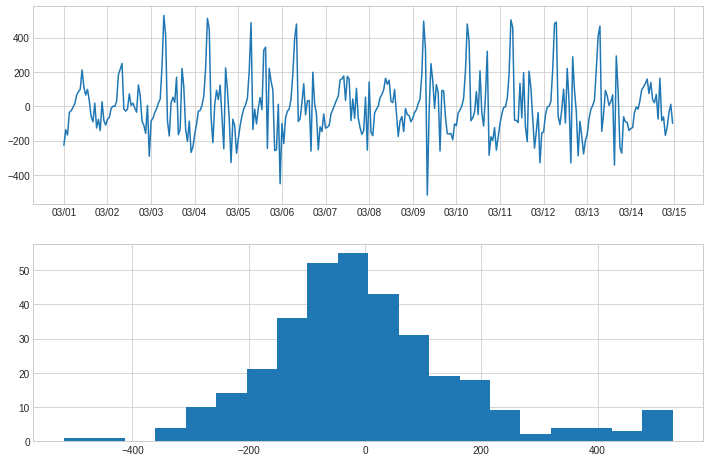

In [75]:
#plot series with differencing:
fig = plot_3weeks_march_and_histogram(ts_diff1)


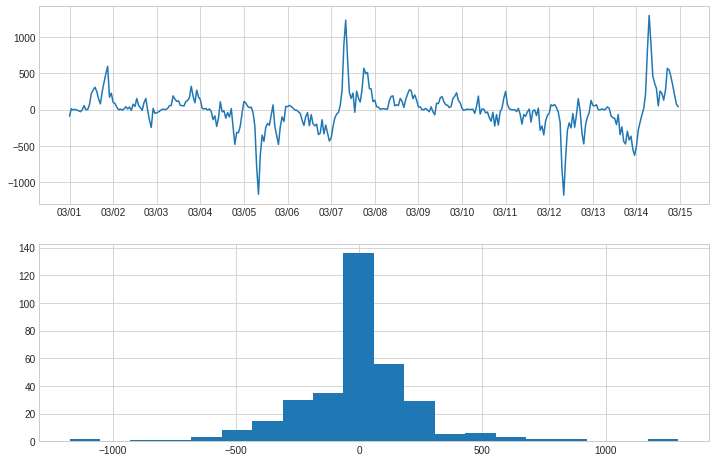

In [17]:
#plot series with differencing:
fig = plot_3weeks_march_and_histogram(ts_diff_24)


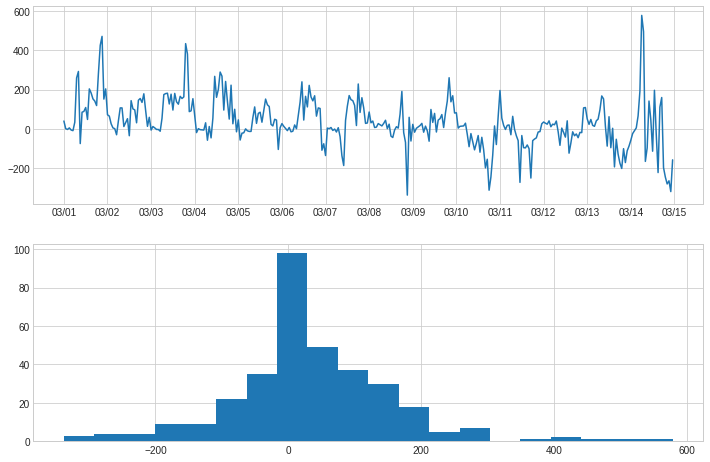

In [18]:
#plot series with differencing:
fig = plot_3weeks_march_and_histogram(ts_diff_168)


/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


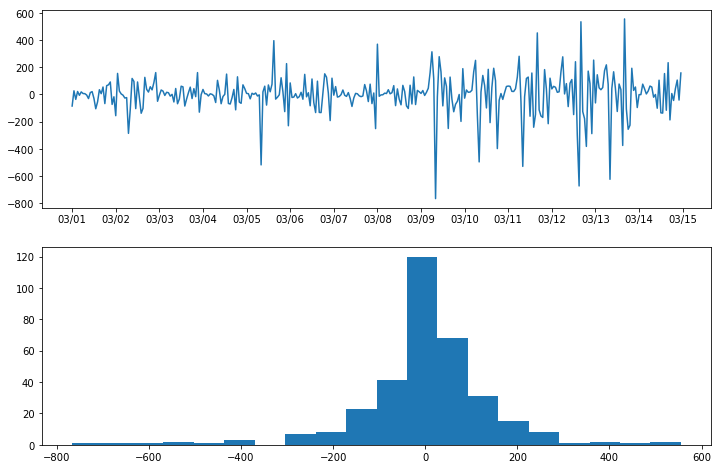

In [72]:
#plot series with differencing:
fig = plot_3weeks_march_and_histogram(ts_diff_1_168)


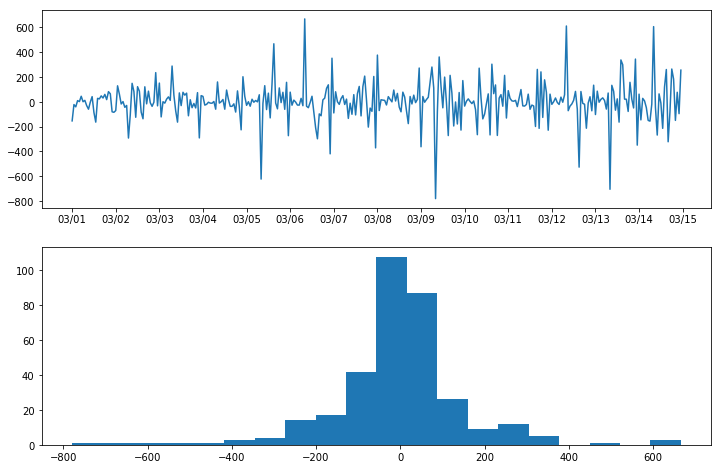

In [74]:
#plot series with differencing:
fig = plot_3weeks_march_and_histogram(ts_diff_1_168_24)


### ACF & PACF with differencing

#### ts_diff_1_168

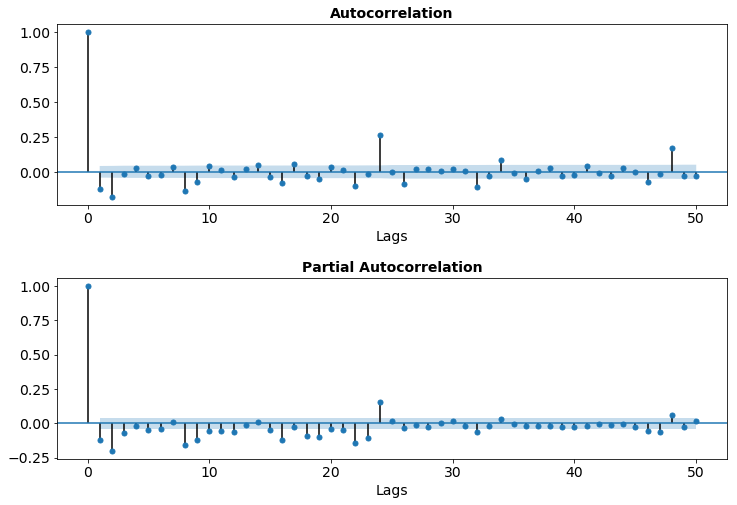

In [59]:
ts_series_to_plot = ts_diff_1_168.loc['2009-03-01':'2009-05']
#ts_series_to_plot = ts_diff_1_168.copy()
fig_acf = plot_acf_pacf(ts_series_to_plot, n_lags=50)


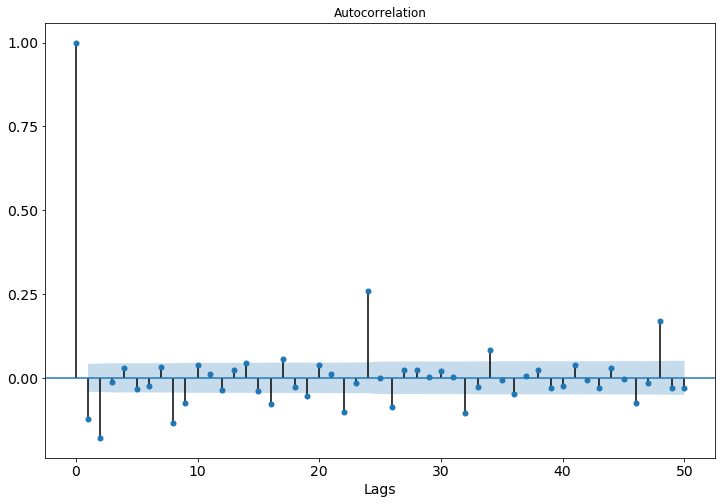

In [60]:
ts_series_to_plot = ts_diff_1_168.loc['2009-03-01':'2009-05']
fig_single_acf= plot_acf_only(ts_series_to_plot, n_lags=50)


#### ts_diff_1_168_24

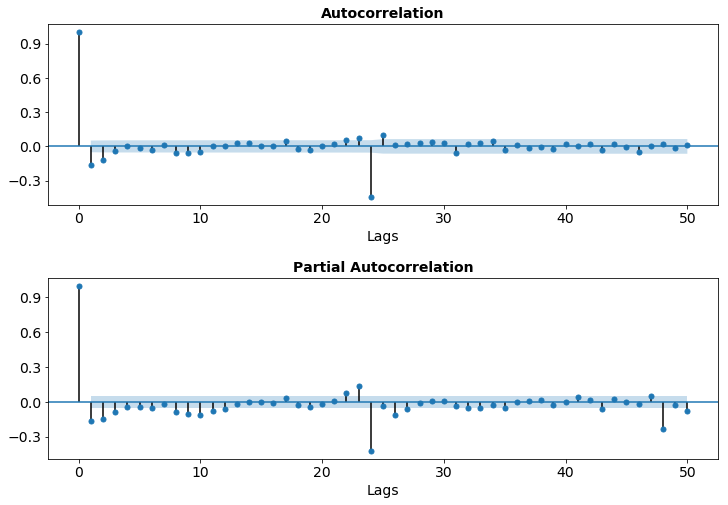

In [61]:
ts_series_to_plot = ts_diff_1_168_24.loc['2009-03-01':'2009-04'].copy()
#ts_series_to_plot = ts_diff_1_168_24.loc['2011-03-01':'2011-04'].copy()
fig_acf = plot_acf_pacf(ts_series_to_plot, n_lags=50)


#### other plots

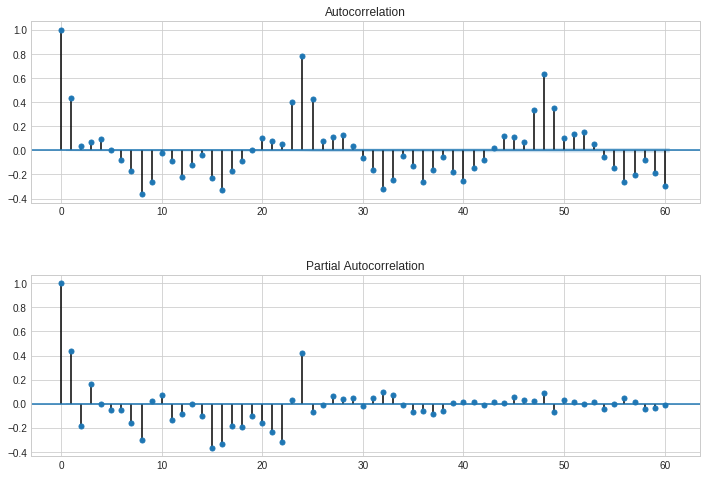

In [91]:
#plot ACF & PACF: 
fig = plot_acf_pacf(ts_diff_1_24)


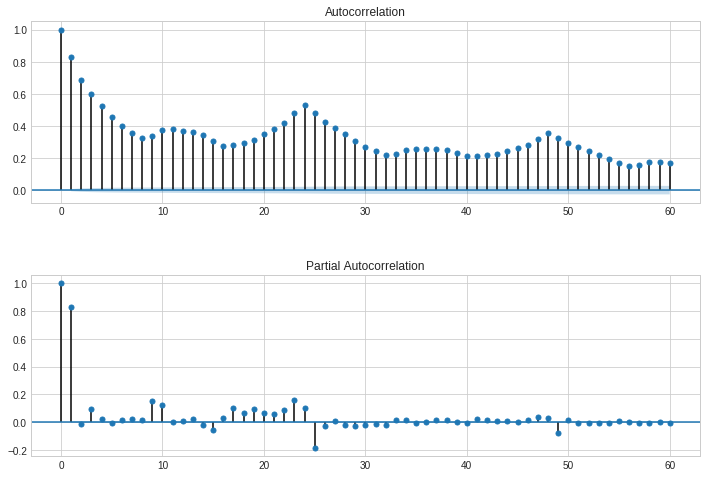

In [22]:
#plot ACF & PACF: 
fig = plot_acf_pacf(ts_diff_168)


### Adfuller Test

In [95]:
#apply adfuller test:
adfuller_test(ts_diff1)
 
    

ADF Statistic: -44.23547209039533
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [96]:
#apply adfuller test:
adfuller_test(ts_diff1)
 
    

ADF Statistic: -44.23547209039533
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [134]:
#apply adfuller test:
stat, p_val = adfuller_test(ts_diff_1_168_24.loc['2009-03-01':'2009-05'])


    

ADF Statistic: -15.572501443956448
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [135]:
p_val

1.9785856352822142e-28

### test differencing scheme on all remaining areas:

In [62]:
#apply differencing to make series stationary

all_diff_series = []
all_stat_val = []
all_p_val = []

for i in range(20):
    
    ts_series_single_area = ts_20largest.iloc[:,i].copy()
    
    ts_diff1 = differencing(ts_series_single_area,1)

    #apply differencing with seasonal lags:
    ts_diff_1_168 = differencing(ts_diff1,168)

    #apply differencing with seasonal lags:
    ts_diff_1_168_24 = differencing(ts_diff_1_168,24)

    all_diff_series.append(ts_diff_1_168_24)
    
    stat, p_val = adfuller_test(ts_diff_1_168_24.loc['2009-03-01':'2009-05'])
    
        
    all_stat_val.append(stat)
    all_p_val.append(p_val)
    
    
    

ADF Statistic: -15.572501443956448
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -14.789181070726634
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -15.924273512132865
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -15.542669447984876
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -14.968658323489933
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -15.647189717658964
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -15.754080914853612
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -16.171181635822293
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -15.551449154038291
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -14.439007613389325
p-

In [65]:
pacf_acf_df = pd.DataFrame()

pacf_acf_df['p_value'] = all_p_val
pacf_acf_df

,p_value
0,1.978586e-28
1,2.184626e-27
2,7.859870e-29
3,2.149395e-28
4,1.209332e-27
5,1.613081e-28
6,1.213529e-28
7,4.363136e-29
8,2.097496e-28
9,7.412966e-27


## Split data: Training / Test

In [13]:
#set years to filter after:
start_train_year = '2009'
last_train_year = '2010'
validation_year = '2011'
test_year = '2012'

#differenced_data = ts_diff1
#differenced_data = ts_diff_168
differenced_data = ts_diff_1_168_24 #based on area 237

#train, valid and test set: based on differenced_data:
train_set, valid_set, test_set = differenced_data.loc[start_train_year:last_train_year], differenced_data.loc[validation_year], differenced_data.loc[test_year]

#input data needs to be floating point values, other values can cause the ARIMA model to fail
train_set = train_set.astype('float64')
valid_set = valid_set.astype('float64')
test_set = test_set.astype('float64')

#create set of all years (without training years)
all_years_set = ts_diff_1_168_24.loc['2011':'2018']
all_years_set = all_years_set.astype('float64')


## Pyramid ARIMA

In [113]:

#Note: a validation set can be also included in fitting process

# Fit model which includes no further differencing: 
arima = auto_arima(train_set, start_q=0, start_p=20, max_p=26, max_q=17, trace=True, max_order = 55, seasonal=False, stationary = True, suppress_warnings=True, 
                   stepwise=True, error_action='ignore', n_jobs = -1)


#get AIC of best model:
print('AIC of best ARIMA', arima.aic())

#get configuration of selected ARIMA Model:
arima.summary()

#get parameters of model:
arima.params()


/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/pyramid/arima/auto.py:379: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Fit ARIMA: order=(20, 0, 0); AIC=197836.416, BIC=198007.136, Fit time=85.011 seconds
Fit ARIMA: order=(0, 0, 0); AIC=200312.692, BIC=200328.212, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0); AIC=199228.707, BIC=199251.987, Fit time=0.177 seconds
Fit ARIMA: order=(0, 0, 1); AIC=198978.265, BIC=199001.545, Fit time=0.137 seconds
Fit ARIMA: order=(19, 0, 0); AIC=197846.076, BIC=198009.036, Fit time=68.125 seconds
Fit ARIMA: order=(21, 0, 0); AIC=197813.991, BIC=197992.471, Fit time=113.042 seconds
Fit ARIMA: order=(21, 0, 1); AIC=197162.429, BIC=197348.669, Fit time=260.466 seconds
Fit ARIMA: order=(22, 0, 2); AIC=196679.619, BIC=196881.379, Fit time=385.714 seconds
Fit ARIMA: order=(21, 0, 2); AIC=196757.115, BIC=196951.115, Fit time=615.184 seconds
Fit ARIMA: order=(23, 0, 2); AIC=195368.287, BIC=195577.808, Fit time=285.217 seconds
Fit ARIMA: order=(23, 0, 1); AIC=196003.137, BIC=196204.897, Fit time=302.247 seconds
Fit ARIMA: order=(23, 0, 3); AIC=194969.735, BIC=195187.015, Fit 

array([ 1.02507353e-04, -3.02841618e-01,  6.40745588e-01,  5.67799855e-02,
        9.48762721e-02,  4.85574531e-03, -1.44586840e-02, -2.88271151e-02,
       -2.56336418e-02,  5.74563686e-03,  5.79891588e-02,  4.93304437e-02,
        4.32347950e-02,  3.52190063e-02,  6.63091420e-03,  5.75784701e-03,
       -2.47227990e-03,  3.28322268e-04, -3.54882848e-05, -1.31986911e-02,
        1.15553403e-02,  2.80365631e-02, -4.25215998e-03,  1.69540936e-02,
       -4.23499539e-01, -9.27184938e-02,  3.28612445e-01, -2.66932733e-02,
       -8.62181296e-01,  2.63803865e-02, -1.37317832e-01])

## SARIMAX based on auto arima parameters

### create model for single area

##### model: 24_0_4

In [26]:
#create model based on train set:
model_sarima = sm.tsa.statespace.SARIMAX(train_set, order=(24,0,4), enforce_invertibility=False, enforce_stationarity = False)
model_sarima_train_fit = model_sarima.fit()

In [136]:
model_sarima_train_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    237   No. Observations:                17327
Model:              SARIMAX(24, 0, 4)   Log Likelihood             -106413.384
Date:                Wed, 11 Sep 2019   AIC                         212884.768
Time:                        15:19:24   BIC                         213109.768
Sample:                    01-09-2009   HQIC                        212958.900
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1000      0.014     -6.972      0.000      -0.128      -0.072
ar.L2          0.0135      0.016      0.845      0.398      -0.018       0.045
ar.L3          0.0140      0.015      0.927      0.354      -0.016       0.044
ar.L4          0.0189      0.016      1.201      0.230      -0.012       0.050
ar.L5         -0.0366      0.008     -4.707      0.000      -0.052      -0.021
ar.L6         -0.0561      0.008     -7.182      0.000      -0.071      -0.041
ar.L7         -0.0542      0.007     -7.644      0.000      -0.068      -0.040
ar.L8         -0.1041      0.007    -14.725      0.000      -0.118      -0.090
ar.L9         -0.0722      0.007    -10.133      0.000      -0.086      -0.058
ar.L10        -0.0090      0.007     -1.273      0.203      -0.023       0.005
ar.L11         0.0050      0.007      0.713      0.476      -0.009       0.019
ar.L12        -0.0030      0.007     -0.409      0.682      -0.017       0.011
ar.L13        -0.0194      0.007     -2.805      0.005      -0.033      -0.006
ar.L14        -0.0358      0.007     -5.243      0.000      -0.049      -0.022
ar.L15        -0.0559      0.007     -7.677      0.000      -0.070      -0.042
ar.L16        -0.0485      0.007     -6.864      0.000      -0.062      -0.035
ar.L17        -0.0162      0.007     -2.309      0.021      -0.030      -0.002
ar.L18        -0.0487      0.007     -6.726      0.000      -0.063      -0.034
ar.L19        -0.0159      0.007     -2.208      0.027      -0.030      -0.002
ar.L20        -0.0173      0.007     -2.482      0.013      -0.031      -0.004
ar.L21        -0.0207      0.007     -3.071      0.002      -0.034      -0.008
ar.L22        -0.0254      0.006     -3.936      0.000      -0.038      -0.013
ar.L23         0.0184      0.006      3.117      0.002       0.007       0.030
ar.L24        -0.4186      0.005    -79.772      0.000      -0.429      -0.408
ma.L1         -0.0663      0.015     -4.298      0.000      -0.097      -0.036
ma.L2         -0.2134      0.017    -12.782      0.000      -0.246      -0.181
ma.L3         -0.1440      0.017     -8.452      0.000      -0.177      -0.111
ma.L4         -0.0767      0.018     -4.245      0.000      -0.112      -0.041
sigma2      1.295e+04     89.626    144.543      0.000    1.28e+04    1.31e+04
===================================================================================
Ljung-Box (Q):                      531.79   Jarque-Bera (JB):              8086.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### fit model on remaining years (single area = 237)

In [ ]:
#create model based on remaining years (2011-2018)
model_sarima_all_years = sm.tsa.statespace.SARIMAX(all_years_set, order=(24,0,4), enforce_invertibility=False, enforce_stationarity = False)
#use parameters of autoarima fitting process:
model_sarima_all_years_fit = model_sarima_all_years.filter(model_sarima_train_fit.params)
#get predictions:
model_sarima_all_years_preds = model_sarima_all_years_fit.predict()

#NOTE: if differencing was applied multiple times, invert differencing has to be applied mutliple times too!
#invert differencing:

model_sarima_all_years_preds_org = multiple_invert_differencing(ts_20largest.iloc[:,0], model_sarima_all_years_preds, [1,168,24])


In [ ]:
#check RMSE of predictions:
for year in range(2011,2019):
    year = str(year)
    rmse = np.sqrt(mean_squared_error(ts_20largest.iloc[:,0][year], model_sarima_all_years_preds_org.loc[year]))
    print(year, rmse)
    
    

##### model: 26_0_4

In [25]:
#create model based on train set:
'''change model name'''
model_sarima_26_0_4_ = sm.tsa.statespace.SARIMAX(train_set, order=(26,0,4), enforce_invertibility=False, enforce_stationarity = False)
model_sarima_train_fit_26_04_ = model_sarima_26_0_4_.fit()

/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
#create model based on remaining years (2011-2018)
model_sarima_all_years_26_04_ = sm.tsa.statespace.SARIMAX(all_years_set, order=(26,0,4), enforce_invertibility=False, enforce_stationarity = False)
#use parameters of autoarima fitting process:
model_sarima_all_years_fit_26_04_ = model_sarima_all_years_26_04_.filter(model_sarima_train_fit_26_04_.params)
#get predictions:
model_sarima_all_years_preds_26_04 = model_sarima_all_years_fit_26_04_.predict()

#NOTE: if differencing was applied multiple times, invert differencing has to be applied mutliple times too!
#invert differencing:


model_sarima_all_years_preds_org_26_04_ = multiple_invert_differencing(ts_20largest.iloc[:,0], model_sarima_all_years_preds_26_04, [1,168,24])


In [ ]:
#check RMSE of predictions:
for year in range(2011,2019):
    year = str(year)
    rmse = np.sqrt(mean_squared_error(ts_20largest.iloc[:,0][year], model_sarima_all_years_preds_org.loc[year]))
    print(year, rmse)
    
    

In [137]:
model_sarima_train_fit_26_04_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    237   No. Observations:                17327
Model:              SARIMAX(26, 0, 4)   Log Likelihood             -106168.602
Date:                Wed, 11 Sep 2019   AIC                         212399.205
Time:                        15:19:53   BIC                         212639.719
Sample:                    01-09-2009   HQIC                        212478.450
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1620      0.372      0.436      0.663      -0.567       0.891
ar.L2          0.5129      0.274      1.873      0.061      -0.024       1.050
ar.L3          0.0341      0.024      1.406      0.160      -0.013       0.082
ar.L4          0.0031      0.016      0.187      0.852      -0.029       0.035
ar.L5          0.0195      0.014      1.387      0.165      -0.008       0.047
ar.L6         -0.0149      0.008     -1.838      0.066      -0.031       0.001
ar.L7         -0.0035      0.009     -0.372      0.710      -0.022       0.015
ar.L8         -0.0485      0.008     -5.818      0.000      -0.065      -0.032
ar.L9         -0.0088      0.021     -0.418      0.676      -0.050       0.032
ar.L10         0.0714      0.011      6.492      0.000       0.050       0.093
ar.L11         0.0521      0.023      2.306      0.021       0.008       0.096
ar.L12         0.0085      0.011      0.792      0.428      -0.013       0.029
ar.L13        -0.0086      0.008     -1.089      0.276      -0.024       0.007
ar.L14        -0.0176      0.008     -2.101      0.036      -0.034      -0.001
ar.L15        -0.0309      0.010     -3.150      0.002      -0.050      -0.012
ar.L16        -0.0167      0.012     -1.401      0.161      -0.040       0.007
ar.L17         0.0268      0.009      3.133      0.002       0.010       0.044
ar.L18        -0.0136      0.013     -1.008      0.314      -0.040       0.013
ar.L19         0.0110      0.014      0.793      0.428      -0.016       0.038
ar.L20         0.0161      0.014      1.188      0.235      -0.010       0.043
ar.L21        -0.0075      0.008     -0.938      0.348      -0.023       0.008
ar.L22        -0.0099      0.008     -1.230      0.219      -0.026       0.006
ar.L23         0.0407      0.007      5.657      0.000       0.027       0.055
ar.L24        -0.4125      0.017    -24.119      0.000      -0.446      -0.379
ar.L25         0.1055      0.163      0.648      0.517      -0.214       0.425
ar.L26         0.2142      0.134      1.601      0.109      -0.048       0.476
ma.L1         -0.3534      0.372     -0.951      0.342      -1.082       0.375
ma.L2         -0.6837      0.345     -1.983      0.047      -1.360      -0.008
ma.L3         -0.0261      0.045     -0.579      0.563      -0.115       0.062
ma.L4          0.0633      0.026      2.441      0.015       0.012       0.114
sigma2       1.29e+04    117.725    109.586      0.000    1.27e+04    1.31e+04
===================================================================================
Ljung-Box (Q):                      388.07   Jarque-Bera (JB):              9093.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using t

### Check of Residuals

#### model: 24_0_4

In [27]:
preds_train_24_0_4_arima = model_sarima_train_fit.predict()

In [87]:
#invert differencing:
preds_train_24_0_4_arima_org = multiple_invert_differencing(ts_20largest.iloc[:,0], preds_train_24_0_4_arima, [1,168,24])

In [88]:
preds_train_24_0_4_arima_org.head()

date
2009-01-09 01:00:00    119.000000
2009-01-09 02:00:00    160.100448
2009-01-09 03:00:00    122.647515
2009-01-09 04:00:00    116.054902
2009-01-09 05:00:00     89.153449
Freq: H, dtype: float64

In [29]:
# get residuals:

resid_org_model_24_0_4 = ts_20largest.iloc[:,0].loc['2009-01-09 01:00:00':'2010'] - preds_train_24_0_4_arima_org

resid_non_inverted_model_24_0_4 = train_set - preds_train_24_0_4_arima

In [100]:
resid_non_inverted_model_24_0_4.head()

date
2009-01-09 01:00:00   -93.000000
2009-01-09 02:00:00    12.587848
2009-01-09 03:00:00    21.528022
2009-01-09 04:00:00   -46.368344
2009-01-09 05:00:00   -56.938015
Freq: H, dtype: float64

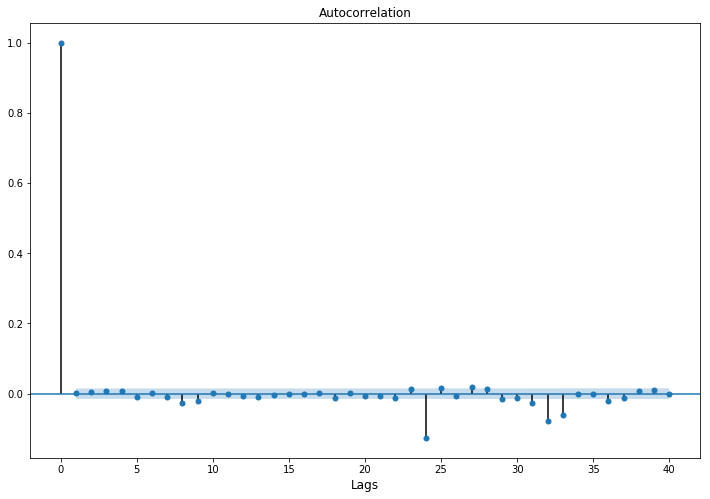

In [96]:
#plot ACF of residuals

resid_acf = plot_acf_only(resid_non_inverted_model_24_0_4, n_lags=40)


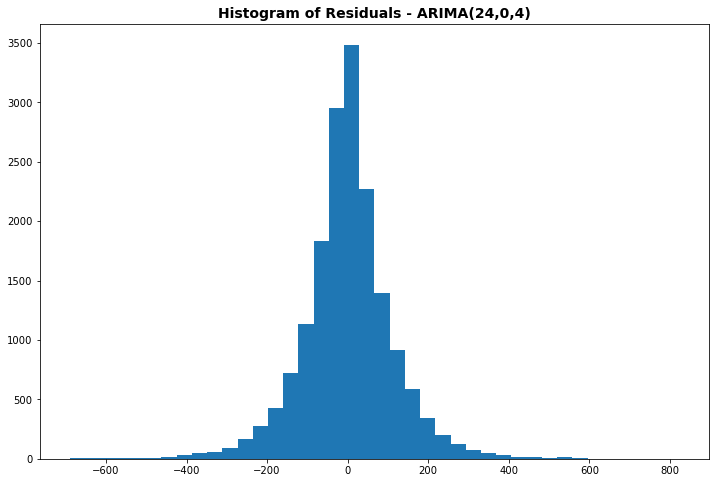

In [33]:
#plot histogram of residuals

hist_resid = plot_hist(resid_non_inverted_model_24_0_4, n_bins=40, plot_title='Histogram of Residuals - ARIMA(24,0,4)')


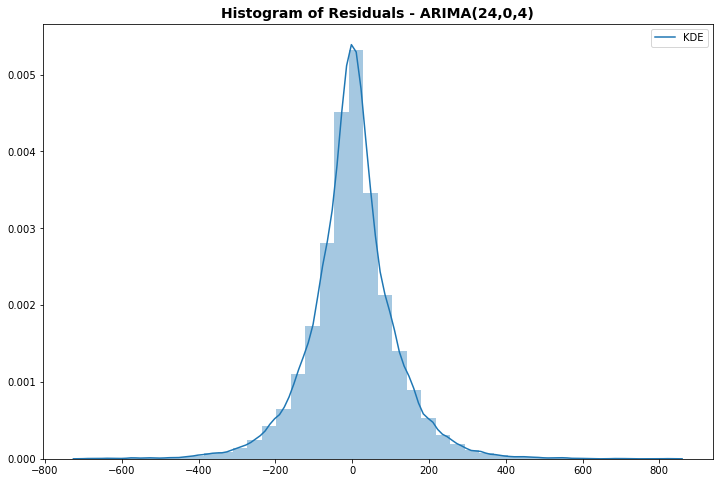

In [128]:
dist_ = plot_dist(resid_non_inverted_model_24_0_4, n_bins=40, plot_title='Histogram of Residuals - ARIMA(24,0,4)')


In [140]:
#standardize residuals:
scaler = StandardScaler()
#reshape resid for scaler:
resid_reshaped = resid_non_inverted_model_24_0_4.values.reshape([resid_non_inverted_model_24_0_4.shape[0],1])

scaler = scaler.fit(resid_reshaped)

#scale train_set:
resid_scaled = scaler.transform(resid_reshaped)
resid_scaled_df = pd.DataFrame(resid_scaled)



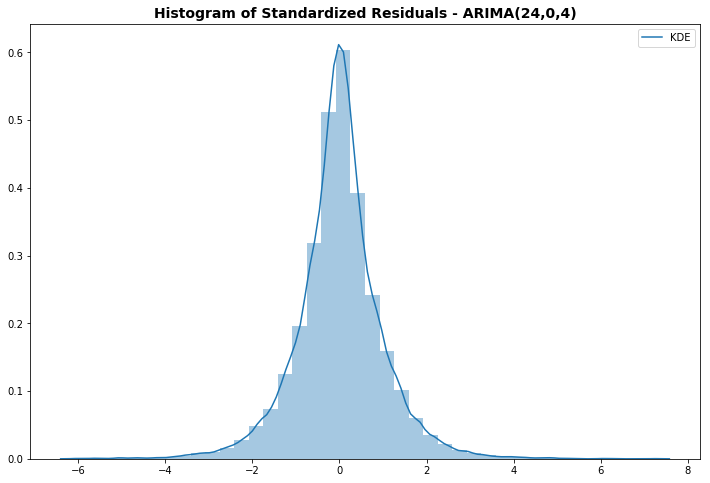

In [131]:
dist_ = plot_dist(resid_scaled_df.values, n_bins=40, plot_title='Histogram of Standardized Residuals - ARIMA(24,0,4)')
#save on Disk:


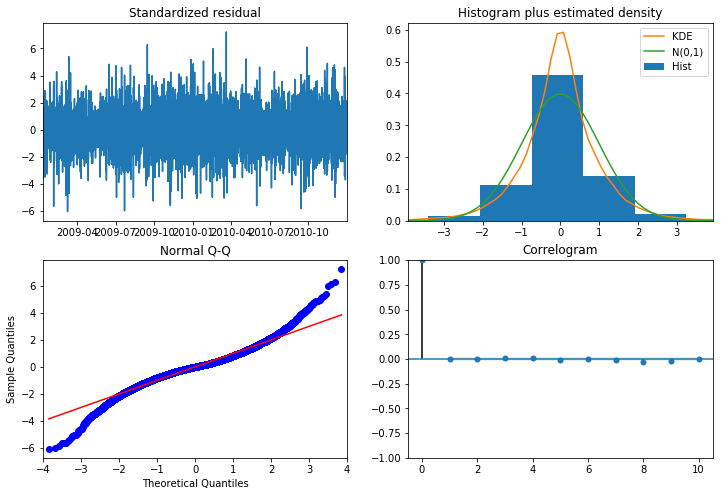

In [119]:
#further diagnostics:
model_sarima_train_fit.plot_diagnostics(figsize=(12,8))
plt.show()

#### model_26_0_4

In [34]:
preds_train_26_0_4_arima = model_sarima_train_fit_26_04_.predict()

In [35]:
#invert differencing:
preds_train_26_0_4_arima_org = multiple_invert_differencing(ts_20largest.iloc[:,0], preds_train_26_0_4_arima, slice('2009','2010'), [1,168,24])

Shape of org. dataset after shift:  (17327,)
Shape of org. dataset after shift:  (17351,)
Shape of org. dataset after shift:  (17519,)


In [36]:
# get residuals:

resid_org_model_24_0_4 = ts_20largest.iloc[:,0].loc['2009-01-09 01:00:00':'2010'] - preds_train_26_0_4_arima_org

resid_non_inverted_model_26_0_4 = train_set - preds_train_26_0_4_arima

In [141]:
#standardize residuals:
scaler = StandardScaler()
#reshape resid for scaler:
resid_reshaped_26_04_ = resid_non_inverted_model_26_0_4.values.reshape([resid_non_inverted_model_26_0_4.shape[0],1])

scaler = scaler.fit(resid_reshaped_26_04_)

#scale train_set:
resid_scaled_26_04_ = scaler.transform(resid_reshaped_26_04_)
resid_scaled_26_04_df = pd.DataFrame(resid_scaled_26_04_)



In [115]:
resid_scaled_df.shape

(17327,)

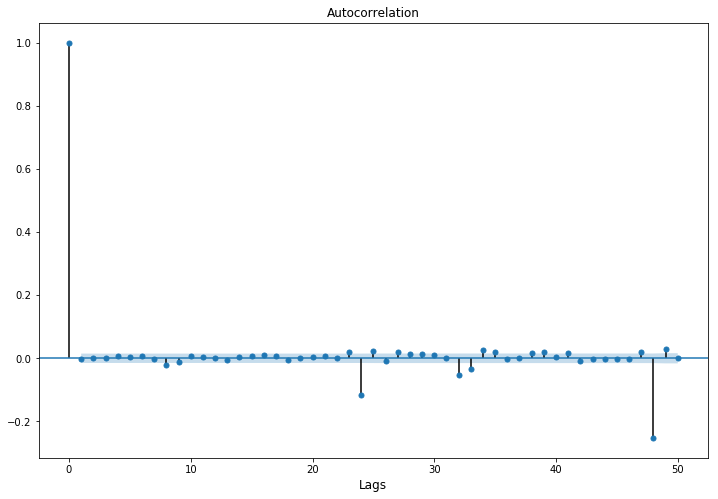

In [111]:
#plot ACF of residuals

resid_acf = plot_acf_only(resid_scaled_df, n_lags=50)


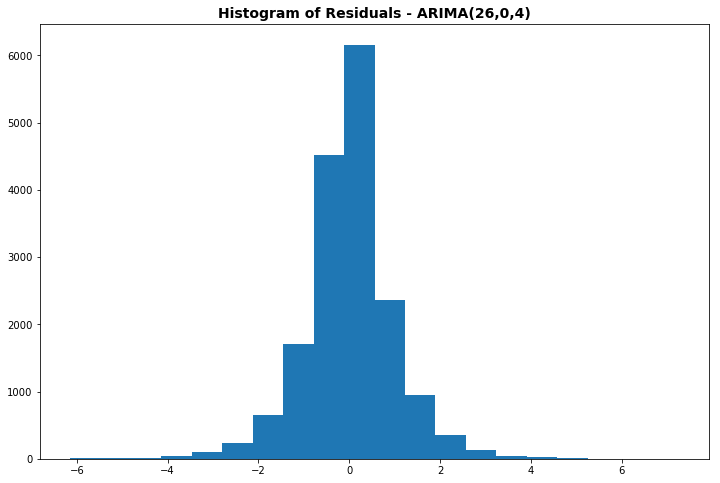

In [116]:
#plot histogram of residuals

hist_resid = plot_hist(resid_scaled_df.values, n_bins=20, plot_title='Histogram of Residuals - ARIMA(26,0,4)')


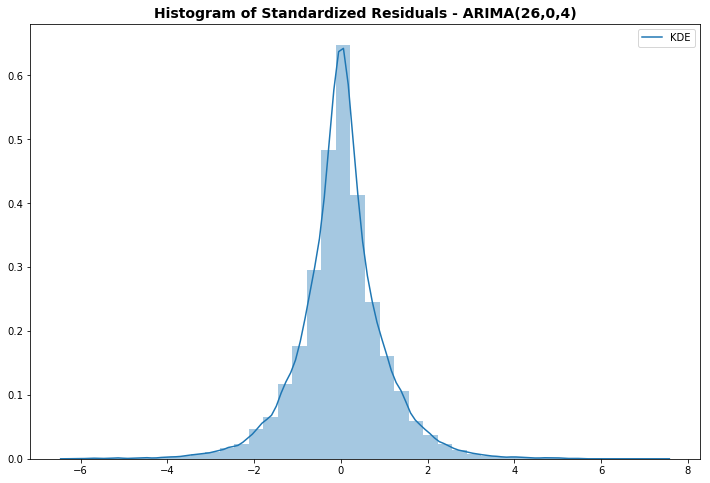

In [139]:
dist_ = plot_dist(resid_scaled_df.values, n_bins=40, plot_title='Histogram of Standardized Residuals - ARIMA(26,0,4)')


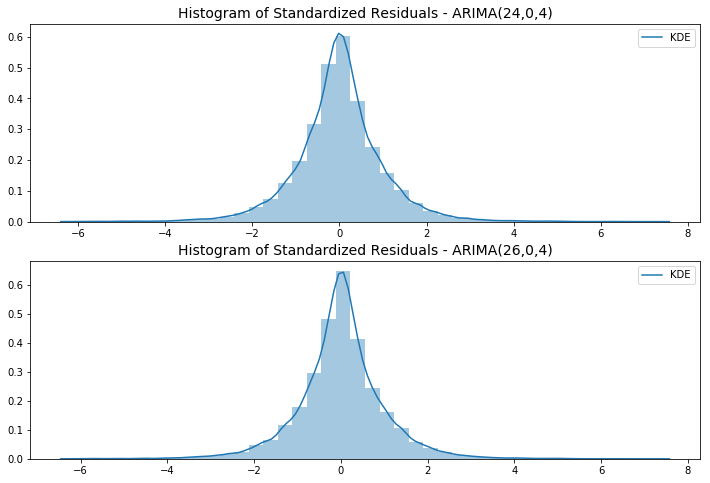

In [148]:
## both models together:
multi_dist = multi_plot_dist(resid_scaled_df.values, resid_scaled_26_04_df.values, n_bins=40, first_plot_title='Histogram of Standardized Residuals - ARIMA(24,0,4)', 
                             second_plot_title='Histogram of Standardized Residuals - ARIMA(26,0,4)')

### Apply and fit SARIMAX on all areas & get preds for all years

In [14]:
def arima_per_area(area_label, org_data_set_diff, start_training_set = '2009', last_training_set = '2010', order_set = (24,0,4)):
    
    #get train_set 
    #NOTE: using "[[]]" returns df 
    train_set = org_data_set_diff[[area_label]].loc[start_training_set:last_training_set]
    
    print('## Create SARIMA model for area ', area_label)
    
    #create SARIMA model based on train set:
    try:
        #create model based on train set for each area:
        model_sarima = sm.tsa.statespace.SARIMAX(train_set, order=order_set, enforce_stationarity = False, enforce_invertibility=False)
        model_sarima_train_fit = model_sarima.fit()
    
    except Exception as exc:
        if 'enforce_stationarity' in str(exc):

            model_sarima = sm.tsa.statespace.SARIMAX(train_set, order=order_set, enforce_stationarity = True, enforce_invertibility=False)
            model_sarima_train_fit = model_sarima.fit()

    
    return model_sarima_train_fit
    

#### get predictions for 20 largest areas:

In [15]:
#create arima model for 20 largest areas and get predictions:

area_label_list = list(ts_20largest.columns)

#prepare differenced dataset:
ts_diff_1 = ts_20largest.diff(1)
ts_diff_1.dropna(inplace=True)
#call function for further differencing:
ts_diff_1_168 = differencing(ts_diff_1,168)
ts_diff_1_168_24 = differencing(ts_diff_1_168,24)


#set order of models:
order_set = (24,0,4)

arima_all_models = {}

'''Start model creation for all areas'''
for i in range(len(area_label_list)):
    #get ARIMA Model for training set of each area:
    arima_training_fit__area_i = arima_per_area(area_label_list[i], ts_diff_1_168_24.copy(), order_set = order_set)
 
    #create model based on remaining years (2011-2018):
    all_years_set = ts_diff_1_168_24.iloc[:,i].loc['2011':'2018']
    #create ARIMA object for remaning years:
    model_sarima_all_years__area_i = sm.tsa.statespace.SARIMAX(all_years_set, order=order_set, enforce_stationarity = False, enforce_invertibility=False)
    
    #use parameters of training set fitting process:
    model_sarima_all_years_fit__area_i = model_sarima_all_years__area_i.filter(arima_training_fit__area_i.params)
    #get predictions (in_sample):
    model_sarima_all_years__preds_i = model_sarima_all_years_fit__area_i.predict()
    
    #invert differencing:  
    model_sarima_all_years__preds_org_i = multiple_invert_differencing(ts_20largest.iloc[:,i], model_sarima_all_years__preds_i, [1,168,24])
    
    #create df to store all predictions:
    
    #initialize df with first area:
    if i < 1:
        model_sarima_all_years__preds_df = model_sarima_all_years__preds_org_i
    
    #add remaining areas:
    else:
        model_sarima_all_years__preds_df = pd.concat([model_sarima_all_years__preds_df, model_sarima_all_years__preds_org_i],axis=1)

    print(model_sarima_all_years__preds_df.shape)
    
    
    #store fitted arima model in dict:
    arima_all_models['area{}'.format(area_label_list[i])] = arima_training_fit__area_i

## Create SARIMA model for area  237
(65711,)
## Create SARIMA model for area  161
(65711, 2)
## Create SARIMA model for area  230
(65711, 3)
## Create SARIMA model for area  79
(65711, 4)
## Create SARIMA model for area  236
(65711, 5)
## Create SARIMA model for area  162
(65711, 6)
## Create SARIMA model for area  170
(65711, 7)
## Create SARIMA model for area  234
(65711, 8)
## Create SARIMA model for area  48


/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(65711, 9)
## Create SARIMA model for area  186
(65711, 10)
## Create SARIMA model for area  142
(65711, 11)
## Create SARIMA model for area  107
(65711, 12)
## Create SARIMA model for area  163
(65711, 13)
## Create SARIMA model for area  68
(65711, 14)
## Create SARIMA model for area  239


/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(65711, 15)
## Create SARIMA model for area  164
(65711, 16)
## Create SARIMA model for area  141


/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(65711, 17)
## Create SARIMA model for area  249


/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(65711, 18)
## Create SARIMA model for area  138


/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(65711, 19)
## Create SARIMA model for area  90


/home/vincent/anaconda3/envs/geo_datascience/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(65711, 20)


In [93]:
#rename columns of df:
model_sarima_all_years__preds_df.columns = area_label_list
model_sarima_all_years__preds_df.head()

,237,161,230,79,236,162,170,234,48,186,142,107,163,68,239,164,141,249,138,90
date,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,438.000000,578.000000,500.000000,1194.000000,618.000000,434.000000,549.000000,582.000000,623.000000,188.000000,227.000000,591.000000,105.000000,589.000000,358.000000,604.000000,352.000000,557.000000,402.000000,490.000000
2011-01-01 01:00:00,75.804396,55.267691,254.398947,843.008323,254.471113,23.878970,251.932605,354.075948,441.165871,247.876146,266.762951,236.821124,93.364199,468.742146,190.426095,31.851921,227.114563,417.657722,-328.683404,253.186117
2011-01-01 02:00:00,271.183607,-100.762619,-278.301082,597.710332,110.746265,168.594863,405.514279,287.179569,134.274387,-104.809615,175.892197,398.099413,40.770972,262.670805,308.681551,108.804076,309.966604,163.746245,-134.352222,165.139880
2011-01-01 03:00:00,217.956373,163.861884,-43.733405,346.183434,220.520055,240.780379,380.406942,166.984181,112.754029,64.988104,160.755023,280.832651,64.300383,155.618557,332.770420,141.901405,319.432518,24.542770,-3.676116,50.530527
2011-01-01 04:00:00,135.145129,118.706832,-3.251722,280.042827,143.047970,247.983145,323.286634,138.812849,280.067062,174.664811,167.375436,339.869358,96.503207,53.118612,275.396900,151.775602,295.683341,-5.926479,12.747043,203.841027


In [94]:
#check RMSE of predictions:
for year in range(2011,2019):
    year = str(year)
    rmse = np.sqrt(mean_squared_error(ts_20largest.iloc[:,0][year], model_sarima_all_years__preds_df.iloc[:,0].loc[year]))
    print(year, rmse)
    
    

2011 116.96304699975292
2012 120.24976948627224
2013 115.42425254546562
2014 113.05584131515268
2015 98.97560057832212
2016 93.75306515695192
2017 88.22657937876694
2018 88.22255116555213


In [95]:
#store results on disk:
#store df:
df_Store_PATH = '/media/...'
file_name = 'ARIMA_2404_model_diff_1_168_24_20largest_areas__2year_train_09_10_preds.csv'

model_sarima_all_years__preds_df.to_csv(df_Store_PATH + file_name, header=True)


#### store models on disk

In [16]:
model_PATH = '/media/...'

key_list = list(arima_all_models.keys())


for key in key_list:
    
    model_to_store = arima_all_models[key]
    
    file_name = 'ARIMA_2404_model__2year_train_{}.pickle.dat'.format(key)
    
    final_model_file = model_PATH + file_name
    
    #save model on disk:
    pickle.dump(model_to_store, open(final_model_file,"wb"))
    
    
    
    


In [19]:
#Test load model:
model_PATH = '/media/...'
file_name = 'ARIMA_2404_model__2year_train_area230.pickle.dat'

model_file = model_PATH + file_name

model_to_load =  pickle.load(open(model_file, "rb"))
model_to_load

## Naive Model & Canary Model

In [109]:
'''### Naive Model ###'''


def naive_model_fast_predictions(complete_ts):

    preds_naive = complete_ts.shift(1)
    preds_naive.dropna(inplace=True)
    
    return preds_naive


In [123]:
def canary_model_fast_predictions(complete_ts):
    
    preds_naive = complete_ts.shift(1)
    mean_delta = np.zeros(len(complete_ts))
    for i in range(1,5):
        help_delta = complete_ts.shift(168*i) - complete_ts.shift(168*i +1)
        mean_delta += help_delta
    
    #Note: the first 672 entries of the shifted df are NaN
    # -> number + NaN = NaN -> mean_delta contains only entries where all shifted values are available
    mean_delta = mean_delta/4
    
    #clip negative delta values:
    #mean_delta.clip(lower=0, inplace=True)
    
    preds_canary = preds_naive + mean_delta
    
    #clip negative values:
    preds_canary.clip(lower=0, inplace=True)
    
    return preds_canary


In [111]:
#call Naive model:

ts_series = ts_20largest.copy()

area_labels = list(ts_20largest.columns)

#get naive predictions for each area:
for i in range(len(area_labels)):
    naive_preds_area_i = naive_model_fast_predictions(ts_series.iloc[:,i])
        
    #initialize df with first result:
    if i < 1:
        naive20__preds_all_years_df = naive_preds_area_i['2011':]
    
    #add remaining areas:
    else:
        naive20__preds_all_years_df = pd.concat([naive20__preds_all_years_df, naive_preds_area_i['2011':]],axis=1)

    



In [121]:
#call canary_model to get predictions:

ts_series = ts_20largest.copy()

area_labels = list(ts_20largest.columns)

#get naive predictions for each area:
for i in range(len(area_labels)):
    canary_preds_area_i = canary_model_fast_predictions(ts_series.iloc[:,i])
        
    #initialize df with first result:
    if i < 1:
        canary20__preds_all_years_df = canary_preds_area_i['2011':]
    
    #add remaining areas:
    else:
        canary20__preds_all_years_df = pd.concat([canary20__preds_all_years_df, canary_preds_area_i['2011':]],axis=1)



In [123]:
print(canary20__preds_all_years_df.shape)
print(naive20__preds_all_years_df.shape)

(65711, 20)
(65711, 20)


In [119]:
#check RMSE of predictions:
for year in range(2011,2019):
    year = str(year)
    rmse = np.sqrt(mean_squared_error(ts_20largest.iloc[:,0][year], df_can.iloc[:,0].loc[year]))
    print(year, rmse)
    
    

2011 104.80626666224727
2012 106.03196881616138
2013 105.90104872206786
2014 102.78795912228783
2015 92.92021855477485
2016 84.04588793647227
2017 76.3300245819602
2018 74.15316176640042


In [124]:
#store Naive & canary results on disk:
#store df:
df_Store_PATH = '/media/...'
file_name_naive = 'Naive_model_20largest_areas__preds_all_years.csv'
file_name_canary = 'Canary_model_20largest_areas__preds_all_years.csv'


naive20__preds_all_years_df.to_csv(df_Store_PATH + file_name_naive, header=True)
canary20__preds_all_years_df.to_csv(df_Store_PATH + file_name_canary, header=True)



In [124]:
#store canary with clipped output instead clipped mean_delta on disk:
#store df:
df_Store_PATH = '/media/...'
file_name_canary = 'Canary_model_clipped_output_20largest_areas__preds_all_years.csv'

canary20__preds_all_years_df.to_csv(df_Store_PATH + file_name_canary, header=True)

